<a href="https://colab.research.google.com/github/muhammedaliuyanik/guidesturkiye-backend/blob/main/Seyahat_oneri_sistemi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import torch
import re
import matplotlib.pyplot as plt

#BERT Modelinin ve Tokenizer'in Yüklenmesi
def extract_bert_features(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# BERT Modeli ve Tokenizer'i Yükleme
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
#Veri Setinin Yüklenmesi
data_file = '/content/drive/MyDrive/Colab Notebooks/places.json'
data = pd.read_json(data_file)

In [ ]:
#Dizi oluşturuluyor filtreleme yapılıyor.

#tag lerde NaN değer varsa null değer ile dolduruluyor.
data[['tag1', 'tag2', 'tag3']] = data[['tag1', 'tag2', 'tag3']].fillna('').astype(str)
#tag1,2,3 ü birleştirerek bir diziye atıyoruz. BERT in özellik vektörlerini çıkarması için
data['combined_text'] = data[['tag1', 'tag2', 'tag3']].agg(' '.join, axis=1)

In [ ]:
# Etiketlerde "history" geçenleri filtreleme
def filter_history_locations(data):
    """
    Belirli bir DataFrame'deki "tag1", "tag2", "tag3" sütunlarında
    "history" veya "historical" kelimesini içeren satırları filtreler.
    """

    # "history" veya "historical" arayan fonksiyon
    def contains_history(tags):
        return any(re.search(r'history|historical', str(tag).lower()) for tag in tags)

    # Her satır için kontrol ve filtreleme işlemi
    filtered_data = data[
        data[['tag1', 'tag2', 'tag3']].apply(contains_history, axis=1)
    ]

    return filtered_data

# "history" veya "historical" içeren lokasyonların filtrelenmesi
data = filter_history_locations(data)

In [ ]:
def get_recommendations_for_city(test_city, source_city, n_recommendations=5):
    """
    Kullanıcının belirttiği bir şehir (source_city) için mevcut lokasyonlardan,
    hedef bir şehirdeki (test_city) "history" veya "historical" etiketi taşıyan lokasyonlara öneriler oluşturur.

    Parametreler:
    - test_city: Önerilerin yapılacağı hedef şehir.
    - source_city: Kullanıcının mevcut olduğu kaynak şehir.
    - n_recommendations: Öneri sayısı (varsayılan: 5).

    Döndürür:
    - recommended_locations: Önerilen lokasyonların DataFrame'i.
    - diversity: Çeşitlilik metriği (düşük benzerlik anlamına gelir).
    """

    # Kaynak ve hedef şehir verilerini filtreleme
    source_city_data = data[data['city'].str.lower() == source_city.lower()]
    target_city_data = data[data['city'].str.lower() == test_city.lower()]

    # Kaynak şehirden yalnızca 3 lokasyonu seçiyoruz
    source_city_data = source_city_data.head(3)

    # Kaynak veya hedef şehirde veri bulunamazsa uyarı ve boş dönüş
    if source_city_data.empty or target_city_data.empty:
        print(f"No historical locations found for {source_city} or {test_city}.")
        return pd.DataFrame(), 0.0

    # Kaynak şehrin metin özelliklerini BERT ile çıkarma
    source_features = np.vstack(
        [extract_bert_features(row['combined_text'], bert_model, tokenizer) for _, row in source_city_data.iterrows()]
    )

    # Hedef şehrin metin özelliklerini BERT ile çıkarma
    target_features = np.vstack(
        [extract_bert_features(row['combined_text'], bert_model, tokenizer) for _, row in target_city_data.iterrows()]
    )

    # Öneri sayısını hedef veri sayısına göre uyarlama
    n_neighbors = min(n_recommendations, len(target_features))
    if n_neighbors == 0:
        print(f"No sufficient data for recommendations in {test_city}.")
        return pd.DataFrame(), 0.0

    # KNN modeli ile benzerlik hesaplama
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn_model.fit(target_features)
    distances, indices = knn_model.kneighbors(source_features)

    # Önerilen lokasyonların seçimi
    recommended_locations = target_city_data.iloc[indices.flatten()]

    # Çeşitlilik metriğinin hesaplanması
    diversity = 1 - cosine_similarity(target_features).mean()

    return recommended_locations, diversity

In [ ]:
#Önerilen lokasyonların doğruluk hesabı. Accuracy
def evaluate_accuracy(recommended_locations, ground_truth):
    if recommended_locations.empty:
        print("No recommendations available.")
        return 0.0

    recommended_ids = recommended_locations['place_id'].tolist()
    correct_recommendations = len(set(recommended_ids) & set(ground_truth))
    accuracy = correct_recommendations / len(ground_truth) if ground_truth else 0
    return accuracy

In [ ]:
#Beş adet şehir için öneri döngüsünün tekrarı
test_cities = ["Antalya", "İzmir", "Alicante", "Kayseri", "Adana"]
source_city = "Gaziantep"

evaluation_results = []
for test_city in test_cities:
    ground_truth = data[data['city'].str.lower() == test_city.lower()]['place_id'].tolist()
    recommended_locations, diversity = get_recommendations_for_city(test_city, source_city)

    if recommended_locations.empty:
        print(f"No recommendations generated for {test_city}.")
        accuracy = 0.0
    else:
        accuracy = evaluate_accuracy(recommended_locations, ground_truth)

    evaluation_results.append({
        "Source City": source_city,
        "Target City": test_city,
        "Accuracy": accuracy,
        "Diversity": diversity
    })

  Source City Target City  Accuracy  Diversity
0   Gaziantep     Antalya  0.588235   0.125004
1   Gaziantep       İzmir  0.833333   0.190710
2   Gaziantep    Alicante  1.000000   0.179881
3   Gaziantep     Kayseri  0.937500   0.196382
4   Gaziantep       Adana  1.000000   0.211023
5 Şehir için Ortalama Doğruluk: 0.87


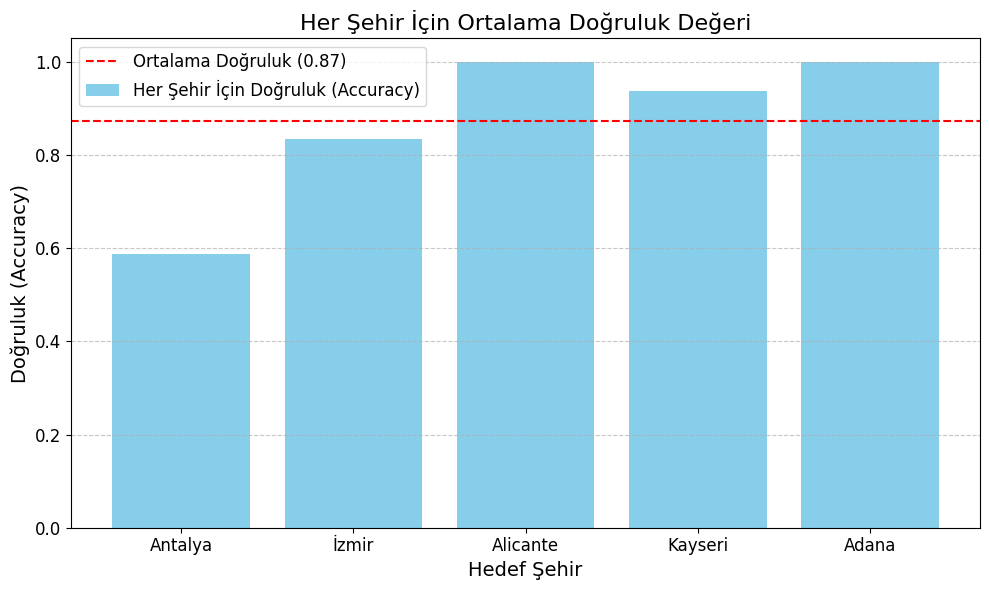

In [16]:
# Sonuçları Görselleştirme
evaluation_df = pd.DataFrame(evaluation_results)
print(evaluation_df)

average_accuracy = evaluation_df['Accuracy'].mean()
print(f"5 Şehir için Ortalama Doğruluk: {average_accuracy:.2f}")

# Grafik Çizimi
plt.figure(figsize=(10, 6))
plt.bar(evaluation_df['Target City'], evaluation_df['Accuracy'], color='skyblue', label='Her Şehir İçin Doğruluk (Accuracy)')
plt.axhline(y=average_accuracy, color='r', linestyle='--', label=f'Ortalama Doğruluk ({average_accuracy:.2f})')

# Grafik Başlık ve Etiketler
plt.title('Gaziantep Şehrinden Seçilen Her Şehir İçin Ortalama Doğruluk Değeri', fontsize=16)
plt.xlabel('Hedef Şehir', fontsize=14)
plt.ylabel('Doğruluk (Accuracy)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Grafiği Görüntüleme
plt.tight_layout()
plt.show()